In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import glob
from random import randint
from utils import *
from skimage.feature import hog


## Dataset Exploration
Labeled images of vehicles and non-vehicles were obtained from [KITTI vision benchmark suit](http://www.cvlibs.net/datasets/kitti/) and [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html).  
You can download the dataset for vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and non-vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip).  

-----------------------------------------------------------------------------------------------------------------------------------

Total vehicle images = 8792   
Total non-vehicle images = 8968  
Image size = 64 $\times$ 64   

The vehicle images in the database are divided as per the angle in which the images were taken. The images also reflect different lighting condiditons.   
The non-vehicle images consists of roads, trees, traffic signs, pavements or asphalts. 

In [16]:
vehicles_dir = glob.glob("./vehicles/*/*.png", recursive=True)
non_vehicles_dir = glob.glob("./non-vehicles/**/*.png", recursive=True)

print(f"The number of vehicle images = {len(vehicles_dir)}")
print(f"The number of non-vehicle images = {len(non_vehicles_dir)}")

get_img_size(vehicles_dir)
get_img_size(non_vehicles_dir)

The number of vehicle images = 8792
The number of non-vehicle images = 8968
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64


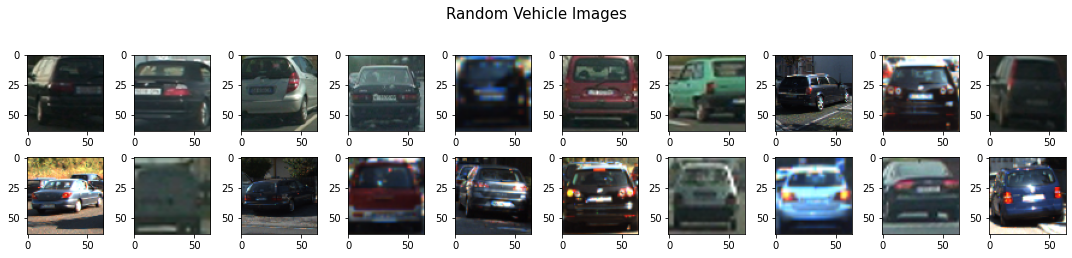

In [17]:

show_random_images(image_dir = vehicles_dir,title = "Random Vehicle Images")

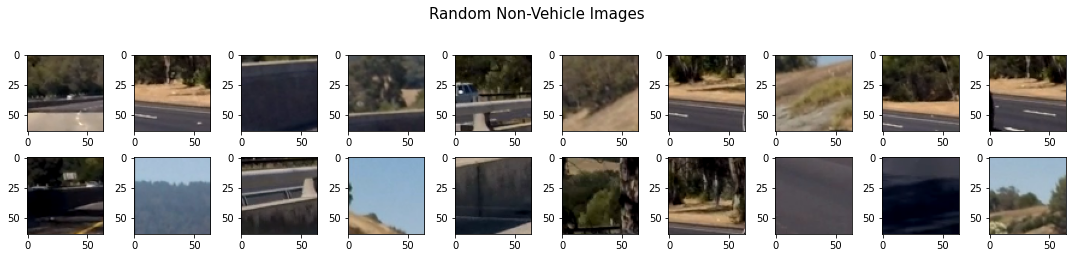

In [18]:
show_random_images(image_dir = non_vehicles_dir,title = "Random Non-Vehicle Images")

## HOG

In [24]:
%run utils.py

# class Arg:
# 	'''
# 	DS to store hog parameters; Used for testing parameter configurations
# 	'''

# 	def __init__(self, color_space, orientation, pix_per_cell, cell_per_block, hog_block_norm = "L2-Hys", color_channel = [0,1,2]):
# 		self.orientation = orientation
# 		self.color_space = color_space
# 		self.pix_per_cell = pix_per_cell
# 		self.cell_per_block = cell_per_block
# 		self.hog_block_norm = hog_block_norm
# 		self.color_channel = color_channel

def image_histogram(image, nbins=32, h_range=(0,256)):
	'''
	to explore color histogram across the 3 color channel
	bins: defines the number of equal-width bins in a range
	range: since the images are RGB range is set to (0,256)
	Comptes the histogram of color across the three channels nad returns a concatenated feature vector
	'''

	channel0 = np.histogram(image[:,:,0], bins = nbins, range = h_range)
	channel1 = np.histogram(image[:,:,1],  bins = nbins, range = h_range)
	channel2 = np.histogram(image[:,:,2],  bins = nbins, range = h_range)
	hist_color = np.concatenate((channel0[0], channel1[0], channel2[0]))
	return hist_color

def hog_features(image, orientation, pix_per_cell, cell_per_block, vis = True, feature_vec = True, norm = "L2-Hys" ):

	'''
	Computes the histogram of oriented gradients. 

	Returns: features vector, corresponding hog image (hog_image)
	
	'''
	features, hog_image = hog(image, 
								orientations = orientation,  
								pixels_per_cell = (pix_per_cell,pix_per_cell), 
								cells_per_block = (cell_per_block,cell_per_block), 
								transform_sqrt = False, 
								visualize = vis, 
								feature_vector = feature_vec, 
								block_norm = norm
							)

	return features, hog_image

def get_all_features(img_dir, arguments):
	features = []
	# if len(img_dir) == 1:
	for im in img_dir:
		image = plt.imread(im)
		
		feature_image = change_color_space(image, arguments.color_space)

		f = []
		for i in arguments.color_channel:
			channel_feature, channel_image = hog_features(feature_image[:,:,i], orientation = arguments.orientation, pix_per_cell = arguments.pix_per_cell, cell_per_block = arguments.cell_per_block)
			f.append(channel_feature)
		f = np.ravel(f)

		spatial_features = resize_image(feature_image, size=(32,32))
		hist_features = image_histogram(feature_image)


		features.append(np.concatenate((spatial_features, hist_features,f)))
	return features


<Figure size 432x288 with 0 Axes>

### Choosing sutiable hog parameters
###### Tested on the original color scale (`RGB`) by varying `orientations`, `pixels_per_cell`, `cells_per_block`

In [25]:
class Parameters:
	'''
	DS to store hog parameters; Used for testing parameter configurations
	'''

	def __init__(self, color_space, orientation, pix_per_cell, cell_per_block, hog_block_norm = "L2-Hys", color_channel = [0,1,2]):
		self.orientation = orientation
		self.color_space = color_space
		self.pix_per_cell = pix_per_cell
		self.cell_per_block = cell_per_block
		self.hog_block_norm = hog_block_norm
		self.color_channel = color_channel


def get_hog_features_for_parameter_set(img_dir, param_set):
	'''
	For testing different hog configurations
	Takes image and parameter set and returns a multi dimensional array such that a[i] = [image, channel1HogImage, channel2HogImage, channel3HogImage, hogParameters]
	'''
	features_set = []
	img = plt.imread(img_dir)
	
	for p in param_set:
		label = f"o = {p.orientation}, px/c = {p.pix_per_cell}, c/b = {p.cell_per_block}"
		hog_viz = []
		cspace_image = change_color_space(img, p.color_space)
		for channel in p.color_channel:
			f, viz = hog_features(cspace_image[:,:,channel], orientation = p.orientation, pix_per_cell = p.pix_per_cell, 
									cell_per_block = p.cell_per_block)
			hog_viz.append(viz)
		
		features_set.append([cspace_image, hog_viz[0], hog_viz[1], hog_viz[2], label])
	return features_set

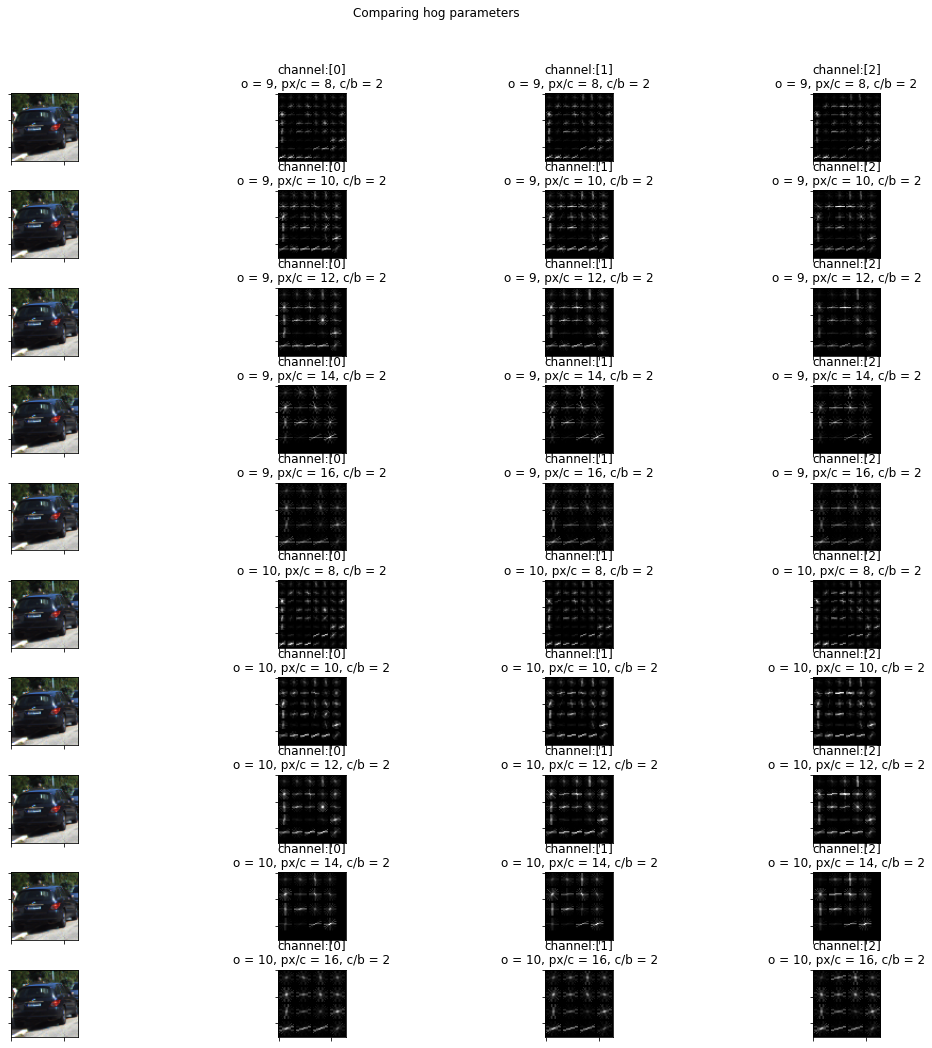

In [21]:
%run utils.py
test_set = [Parameters("RGB", 9, 8, 2),
	Parameters("RGB", 9, 10, 2),
	Parameters("RGB", 9, 12, 2),
	Parameters("RGB", 9, 14, 2),
	Parameters("RGB", 9, 16, 2),
	Parameters("RGB", 10, 8, 2),
	Parameters("RGB", 10, 10, 2),
	Parameters("RGB", 10, 12, 2),
	Parameters("RGB", 10, 14, 2),
	Parameters("RGB", 10, 16, 2)]

test_vehcle_image = vehicles_dir[randint(0,8000)]
feature_set = get_hog_features_for_parameter_set(img_dir= test_vehcle_image, param_set = test_set)
feature_set_viz(feature_set, title = "Comparing hog parameters ")




10-10-2
9-10-2

In [99]:
actual = Parameters("RGB", 11,14,2)

vehicles_features = get_all_features(vehicles_dir, actual)
non_vehicles_features = get_all_features(non_vehicles_dir, actual)

In [13]:
actual = Parameters("RGB", 11,14,2)
print(actual.__dict__)

{'orientation': 11, 'color_space': 'RGB', 'pix_per_cell': 14, 'cell_per_block': 2, 'hog_block_norm': 'L2-Hys', 'color_channel': [0, 1, 2]}


In [26]:
shorltilst_parameter = [Parameters("HSV", 10,10,2),
						Parameters("HSV", 9,10,2), 
						Parameters("HSV", 9,8,2),
						Parameters("HSV", 15,9,2),
						Parameters("LUV", 10,10,2),
						Parameters("LUV", 9,10,2), 
						Parameters("LUV", 9,8,2),
						Parameters("LUV", 15,9,2),
						Parameters("YCrCb", 10,10,2),
						Parameters("YCrCb", 9,10,2), 
						Parameters("YCrCb", 9,8,2),
						Parameters("YCrCb", 15,9,2),]

for p in shorltilst_parameter:
	file_name = f"{p.color_space}_{p.orientation}_{p.pix_per_cell}_{p.cell_per_block}.p"
	
	vehicles_features = get_all_features(vehicles_dir, p)
	non_vehicles_features = get_all_features(non_vehicles_dir, p)

	
	feat = {}
	feat["vehicles"] = vehicles_features
	feat["non-vehicles"] = non_vehicles_features
	pickle.dump(feat, open(f"./configurations/{file_name}", 'wb') )




KeyboardInterrupt: 

In [2]:
import pickle
dist_pickle = pickle.load( open("./configurations/RGB_11_14_2.p.p", "rb" ) )
vec_fe = dist_pickle["vehicles"]
nv_fec = dist_pickle["non-vehicles"]

In [9]:

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline
# Preserve State to compare parameter tuning 


# Create an array stack of feature vectors
X = np.vstack((vec_fe, nv_fec)).astype(np.float64)        
print(len(X))                
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vec_fe)), np.zeros(len(nv_fec))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

# print('Using spatial binning of:',spatial,'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

17760
Feature vector length: 14208
13.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9764
My SVC predicts:      [1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
For these 10 labels:  [1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
0.00136 Seconds to predict 10 labels with SVC


C:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Sliding Window search

In [ ]:
def search_cars(image_dir, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, h_bins, y_startstop_scale, h_shift = 0 , vis = False):
	box_detection_list = list
	box_vis_list = list

	#normalize image
	img = plt.imread(image_dir)
	img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
	img = img.astype(np.float64)/255

	for (ystart, ystop, scale) in y_startstop_scale:
		box = []
		img_search = img[ystart:ystop, :, :]  #cropping image
		if scale != 1:
			imshape = img_search.shape
			img_search = cv2.resize(img_search, (int(imshape[1]/scale), int(imshape[0]/scale)))
		
		channel0 = img_search[:,:,0]
		c0hog, c0img = hog_features(channel0, orient, pix_per_cell, cell_per_block, feature_vec=False)

		channel1 = img_search[:,:,1]
		c1hog, c1img = hog_features(channel1, orient, pix_per_cell, cell_per_block, feature_vec=False)

		channel2 = img_search[:,:,2]
		c2hog, c2img = hog_features(channel2, orient, pix_per_cell, cell_per_block, feature_vec=False)
	

		#defining blocks
		crop_image_shape = img_search.shape
		xblock =  int(crop_image_shape[1]/pix_per_cell)- cell_per_block + 3
		yblock = int(crop_image_shape[0]/ pix_per_cell)- cell_per_block + 1
		features_per_block = orient*(cell_per_block**2)

		## window
		window = 64
		next_step = 2 # how many cells to step
		blocks_per_window = int(window/pix_per_cell)-cell_per_block + 1
		xstep = int((xblock - blocks_per_window)/next_step)
		ystep = int((yblock - blocks_per_window)/next_step)

